## Midterm Exam - NLP - Spring 2024

### General Instructions
- Answer ALL mandatory questions.
- Time Allocated: 3 hours
- This is an individual examination; you are NOT allowed to receive help from your peers.
- You are free to use class notes, notebooks and the internet to refer to online documentation and examples, including usage of existing code.
- Use of ChatGPT is strictly prohibited.


#### Good Luck!!!

<br>

### **Problem Statement**

<br>

## Intro

<br>

<img src = "https://www.surveysensum.com/wp-content/uploads/2020/02/SENTIMENT-09-1.png">

<br>

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

For example, it contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines:

The information of main attributes for this project as follows;

* **`airline_sentiment`** : Sentiment classification.(positivie, neutral, and negative)
* **`negativereason`** : Reason selected for the negative opinion
* **`airline`** : Name of 6 US Airlines('Delta', 'United', 'Southwest', 'US Airways', 'Virgin America', 'American')
* **`text`** : Customer's opinion

<br>

**Objective**

You are given a dataset of US Airline tweets and their sentiment. The task is to do sentiment analysis about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").


### **Load the libraries**

In [1]:
# Install the pyLDAvis library
!pip install pyLDAvis

In [2]:
#importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import warnings
import string
import spacy
import gensim

import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

from sklearn.model_selection import StratifiedKFold, train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.similarities import MatrixSimilarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from collections import Counter
from gensim.matutils import corpus2csc, sparse2full, corpus2dense
from wordcloud import WordCloud
from sklearn.utils import resample
from wordcloud import WordCloud,STOPWORDS
from gensim.models.coherencemodel import CoherenceModel

%matplotlib inline

nltk.download('stopwords')
stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')

# Visualize the topics
pyLDAvis.enable_notebook()
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/maria/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to /Users/maria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the dataset

Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). The information of some of the main attributes for this project are as follows:

* **`airline_sentiment`** : Sentiment classification.(positivie, neutral, and negative)
* **`negativereason`** : Reason selected for the negative opinion
* **`airline`** : Name of 6 US Airlines('Delta', 'United', 'Southwest', 'US Airways', 'Virgin America', 'American')
* **`text`** : Customer's opinion

In [3]:
# 1. Load the dataset from https://raw.githubusercontent.com/satyajeetkrjha/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv
# using as normal the pandas .read_csv() function. Store in a new variable named 'data'
# 2. Print the dimensionality of data
# 3. Preview the first few rows of data

data = pd.read_csv('https://raw.githubusercontent.com/satyajeetkrjha/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv')
print(data.shape)
data

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [4]:
# Get the overall information of the data DataFrame (data types, missing values, etc.)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
# Get all the unique airline names within 'data' and store them in a variable 'airlines'. Which feature would you use?
# This list qill be used later on in the analysis
# Print the 'airlines' results

print('Unique Airline Names:')
airlines = data['airline'].unique().tolist()
airlines

Unique Airline Names:


['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American']

In [6]:
# 1. Set the column 'tweet_id' as the index of data (if you don't know how, you can drop it. Alternatively, the next step will sort this out).
# Remember to conduct this step inplace or with assignment back to "data" for any changes to take effect
# 2. Select and keep ONLY a subset of the features/columns: keep only 'text' and 'airline_sentiment' columns, and re-assign back to data (overwrite data)
# 3. Preview once more the results of data as a sanity check. Have your changes gone through?

data.set_index('tweet_id', inplace = True)
data

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN


In [7]:
data = data[['text', 'airline_sentiment']]
data

,text,airline_sentiment
tweet_id,,
570306133677760513,@VirginAmerica What @dhepburn said.,neutral
570301130888122368,@VirginAmerica plus you've added commercials t...,positive
570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral
570301031407624196,@VirginAmerica it's really aggressive to blast...,negative
570300817074462722,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
569587686496825344,@AmericanAir thank you we got on a different f...,positive
569587371693355008,@AmericanAir leaving over 20 minutes Late Flig...,negative
569587242672398336,@AmericanAir Please bring American Airlines to...,neutral


In [8]:
# Drop the duplicates within data. Remember to assign back or conduct this step with replacement.
# Sanity check: print the dimensionality of 'data' before and after the drop. Was your drop successful?

data.shape

(14640, 2)

In [9]:
data = data.drop_duplicates()
data.shape

(14452, 2)

In [10]:
# Check for null values in data; you can return True/False, counts or any other solution of your choice to investigate for missing values

data.isnull().sum().sum() 

0

In [11]:
# Can you print the 'text' (column) of one random sample in data?

data['text'].sample(1)

tweet_id
569922853266694145    @united @JMS2802 : nothing like supporting you...
Name: text, dtype: object

# **EDA**

### **Counts per type of Sentiment**

In [12]:
# Get the number (frequency/count) of instances (samples) per each sentiment class (this will be a useful insight for the ML classifier later on).
# Store in a variable with a name of your choice and print the results

countpersentiment = data['airline_sentiment'].value_counts()
countpersentiment

airline_sentiment
negative    9087
neutral     3067
positive    2298
Name: count, dtype: int64

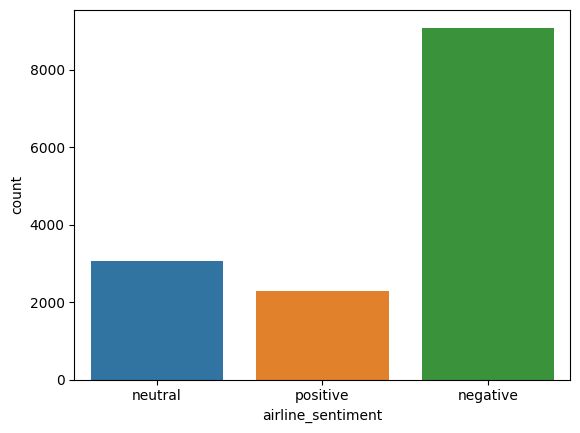

In [13]:
# Use the variable above to plot a seaborn countplot

sns.countplot(x="airline_sentiment", data=data);

In [14]:
# - What do you observe?? Briefly describe here your findings
# we can easily observe that the majority of the comments that the airline receives are by far negative ones (around 9k), 
# followed by neutral ones (around 3k) and then followed by positive ones (around 2k)

### WordCloud : Keyword analysis
WordCloud is one of the easiest way to show which word mainly(frequently) appears in the set of sentences.

But it can be just one of pieces of visualization if there's no appropriate text preprocessing before drawing it.

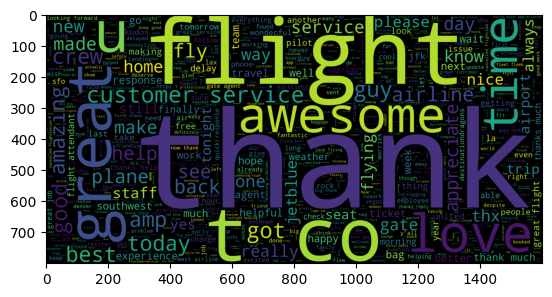

In [102]:
#  Bonus activity: can you filter and draw a Wordcloud of only the positive sentiment cases? Use also STOPWORDS from WordCloud

df_pos = data[data['airline_sentiment'] == "positive"]

wordcloud = WordCloud(stopwords = STOPWORDS,max_words = 1000 , width = 1600 , height = 800,
                     collocations=True).generate(" ".join(df_pos['final_text']))
plt.imshow(wordcloud)

Wordcloud for Negative sentiments of tweets

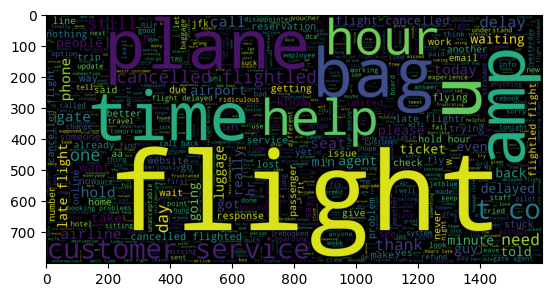

In [103]:
#  Bonus activity: can you filter and draw a Wordcloud of only the negative sentiment cases? Use also STOPWORDS from WordCloud

df_neg = data[data['airline_sentiment'] == "negative"]

wordcloud = WordCloud(stopwords = STOPWORDS,max_words = 1000 , width = 1600 , height = 800,
                     collocations=True).generate(" ".join(df_neg['final_text']))
plt.imshow(wordcloud)


## **Text pre-processing of the tweet text data**

Now, we will clean the tweet text data and apply classification algorithms on it

In [17]:
# Define a function named 'lowercase' to lowercase your text in data

def lowercase(text):
    return text.lower() 

In [18]:
# Apply your 'lowercase' function to lowercase your data on the 'text' feature of data.
# Remember to reassign back to the same column for the changes to take effect.
# Preview your results

data['text'] = data['text'].apply(lowercase)
data['text'].head()

/var/folders/77/p4n_rpm13nqg_blc8tjb5qlc0000gn/T/ipykernel_4002/3292289235.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(lowercase)


tweet_id
570306133677760513                  @virginamerica what @dhepburn said.
570301130888122368    @virginamerica plus you've added commercials t...
570301083672813571    @virginamerica i didn't today... must mean i n...
570301031407624196    @virginamerica it's really aggressive to blast...
570300817074462722    @virginamerica and it's a really big bad thing...
Name: text, dtype: object

In [19]:
# Define a function named 'remove_stopwords' to remove stopwords from your text.
# BONUS / Extra points: you may also wish to append to your stopwords the names of the airlines that you had previously stored in the variable 'airlines'
# You may also consider pre-processing these values before appending them.
# Optionally, you can also append any other frequently encountered words in your stopwords.

def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

In [20]:
# Apply your 'remove_stopwords' function to remove the stopwords from your 'text' feature of data.
# Remember to reassign back to the same column for the changes to take effect.
# Preview your results

data['text'] = data['text'].apply(remove_stopwords)
data['text'].head()

/var/folders/77/p4n_rpm13nqg_blc8tjb5qlc0000gn/T/ipykernel_4002/2701302344.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(remove_stopwords)


tweet_id
570306133677760513                       @virginamerica @dhepburn said.
570301130888122368    @virginamerica plus added commercials experien...
570301083672813571    @virginamerica today... must mean need take an...
570301031407624196    @virginamerica really aggressive blast obnoxio...
570300817074462722                  @virginamerica really big bad thing
Name: text, dtype: object

In [21]:
# Define one or more functions to perform ****at least one more additional**** pre-processing step of your choice based on the data that you observe!
# The cleaner the data, the higher the mark for this activity :D

def remove_usernames(text):
    if isinstance(text, str):
        text = re.sub(r'@[^\s]+', '', text)
    return text

In [22]:
# Justify and briefly describe your choice of pre-processing step(s) here

data['text'] = data['text'].apply(remove_usernames)
data['text'].head()

#i chose to remove the usernames in the comments because i didn't want to keep the mentioned names

/var/folders/77/p4n_rpm13nqg_blc8tjb5qlc0000gn/T/ipykernel_4002/1810654896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(remove_usernames)


tweet_id
570306133677760513                                                said.
570301130888122368          plus added commercials experience... tacky.
570301083672813571           today... must mean need take another trip!
570301031407624196     really aggressive blast obnoxious "entertainm...
570300817074462722                                 really big bad thing
Name: text, dtype: object

In [23]:
# Create a list of the 'text' column from data. Store in a new variable named 'text_list'.
# Preview the first entry of your text_list

text_list = data['text'].values.tolist()
text_list[0]

'  said.'

In [24]:
type(text_list)

list

In [25]:
# Define a function to perform lemmatization, named 'lemmatization'.
# Bonus: allow postags only NOUN and ADJ

nlp = spacy.load('en_core_web_sm')
def lemmatization(text, allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in text:
            doc = nlp(sent) 
            output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [26]:
# Run your lemmatization function on text_list (remember, this is a list, not a DataFrame so you cannot use apply())
# Store in a new variable named 'tokenized_reviews'
### THIS STEP MAY TAKE A WHILE TO EXECUTE ###

tokenized_reviews = lemmatization(text_list)
tokenized_reviews

[[],
 ['commercial', 'tacky'],
 ['today', 'trip'],
 ['aggressive',
  'blast',
  'obnoxious',
  'entertainment',
  'guest',
  'face',
  'little',
  'recourse'],
 ['big', 'bad', 'thing'],
 ['flight', 'seat', 'bad', 'thing'],
 ['time', 'ear', 'worm'],
 ['prime', 'opportunity', 'man', 'hat', 'parody'],
 [],
 ['amazing', 'hour', 'good'],
 ['suicide', 'second', 'cause', 'death', 'teen'],
 ['pretty', 'graphic', 'minimal', 'iconography'],
 ['great', 'deal', '2nd', 'trip', '1st', 'trip', 'p'],
 ['fabulous',
  'seductive',
  'sky',
  'stress',
  'travel',
  'http://t.co/ahlxhhkiyn'],
 ['thank'],
 ['pdx', 'schedule'],
 ['flight', 'great', 'thing'],
 ['last', 'week', 'seat', 'due', 'large', 'gentleman'],
 [],
 ['awesome', 'bo'],
 ['first', 'fare', 'time', 'carrier', 'seat', 'available', 'select'],
 ['graphic', 'http://t.co/ut5grrwaaa'],
 ['hipster', 'innovation', 'good', 'brand'],
 ['bos&gt;la'],
 ['guy',
  'seating',
  'seating',
  'friend',
  'guy',
  'seat',
  '😡',
  'free',
  'internet'],
 ['s

In [27]:
# Concatenate the tokens into single sentences once again, creating a new feature within data named 'final_text'

data['final_text']= ''

for i in range(len(text_list)):
    data['final_text'].iloc[i] = "".join(text_list[i])
data.head()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,text,airline_sentiment,final_text
tweet_id,,,
570306133677760513,said.,neutral,said.
570301130888122368,plus added commercials experience... tacky.,positive,plus added commercials experience... tacky.
570301083672813571,today... must mean need take another trip!,neutral,today... must mean need take another trip!
570301031407624196,"really aggressive blast obnoxious ""entertainm...",negative,"really aggressive blast obnoxious ""entertainm..."
570300817074462722,really big bad thing,negative,really big bad thing


# **Vectorization**

In [28]:
# Store the final_text column from data as your variable X
# Store the airline_sentiment column from data as your class vector y

X = data['final_text']
y = data['airline_sentiment']
X
y

tweet_id
570306133677760513     neutral
570301130888122368    positive
570301083672813571     neutral
570301031407624196    negative
570300817074462722    negative
                        ...   
569587686496825344    positive
569587371693355008    negative
569587242672398336     neutral
569587188687634433    negative
569587140490866689     neutral
Name: airline_sentiment, Length: 14452, dtype: object

In [29]:
# In this step we want to map the classes 'positive', 'neutral' and 'negative' to numerical values
# Instantiate a LabelEncoder() object and store in a variable named 'le'
# Fit and transform your LabelEncoder to your y class variable

le = LabelEncoder()
y = le.fit_transform(y)
y

array([1, 2, 1, ..., 1, 0, 1])

### The data is split in the standard ratio

In [30]:
# Use the holdout method from sklearn to split your data into train and test. Set the random_state to 42 and use stratification.
# Print the dimensionality of the end results as a sanity check

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (10839,)
X_test shape:  (3613,)


In [31]:
# Import the library of the vectorization technique of your choice

from sklearn.feature_extraction.text import CountVectorizer

In [32]:
# Briefly justify your choice for this particular vectorizer

# i chose the “bags-of-words” representation which ignores structure and simply counts how often each word occurs. 
# CountVectorizer allows us to use the bags-of-words approach, by converting a collection of text documents into
# a matrix of token counts.

In [33]:
# Instantiate a vectorizer of your choice into a new variable named 'vect'

vect = CountVectorizer().fit(X_train)
vect

CountVectorizer()

In [34]:
# Can you also create/ instantiate your vectorizer using unigrams and bigrams?
# Optional arguments to consider can be: min_df, max_df and max_features
# Store in a variable 'vect_grams'

vect_grams = CountVectorizer(min_df = 5, max_df = 20, ngram_range = (1,2)).fit(X_train)

In [35]:
# Apply any of the two afore-mentioned vectorizers to your train and test data to convert the text into numbers,
# and store the results in X_train_vec and X_test_vec respectively

X_train_vec = vect.transform(X_train)
X_test_vec = vect.transform(X_test)

# **Model Building**

In [36]:
# Import the Supervised Learning algorithm (classification model) of your choice

from sklearn.svm import LinearSVC

In [37]:
# 1. Instantiate your ML model using any hyperparameters of your choice (no need for tuning)
# 2. Fit your model to your train data
# 3. Predict your test data. Store into a variable named 'pred'
# 4. Report the accuracy score between your predicted and real test values

SVCmodel = LinearSVC()
SVCmodel.fit(X_train_vec, y_train)
y_pred = SVCmodel.predict(X_test_vec)

In [38]:
# Print the classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2272
           1       0.54      0.56      0.55       767
           2       0.68      0.66      0.67       574

    accuracy                           0.75      3613
   macro avg       0.69      0.69      0.69      3613
weighted avg       0.75      0.75      0.75      3613



In [39]:
# Build the confusion matrix between your predicted and real test values
# Store into a new variable named 'cm'

cm = confusion_matrix(y_test, y_pred)
cm

array([[1908,  270,   94],
       [ 256,  429,   82],
       [ 103,   92,  379]])

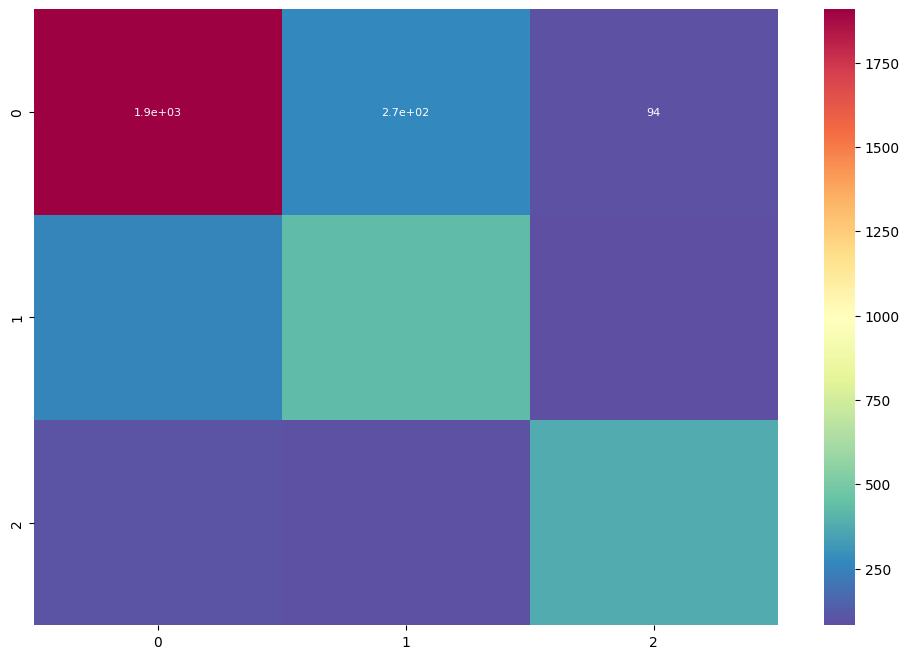

In [40]:
# Extra: plot in a heatmap the confusion matrix

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, 
            annot=True, 
            annot_kws={'size': 8}, 
            cmap="Spectral_r");

In [41]:
# What do you observe in your results? Describe your findings

# we can see that the true mapped values to 0 and the the predicted mapped values to 0 have the highest correlation

# **Unsupervised Learning - Topic Modelling**

In [64]:
# Create a corpora.Dictionary by passing the tokenized_reviews. Store in a new variable 'dictionary'

dictionary = corpora.Dictionary(tokenized_reviews)

texts = tokenized_reviews

In [65]:
print(tokenized_reviews[1])

['commercial', 'tacky']


In [69]:
# Create the doc_term_matrix from your tokenized_reviews

doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [70]:
# Instantiate the LDA model and store it in a variable 'LDA''
# Build your LDA model using any parameters of your choice vy advising the documentation

# *********** Write comments next to every argument you have selected to use, justifying their entries/values

LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=10, #set to 10
                random_state=100, #alpha and beta are hyperparameters that affect sparsity of the topics
                chunksize=100,
                passes=10, #controls how often we train the model on the entire corpus
                iterations=10) #controls how often we repeat a particular loop over each document

In [71]:
# Print the Keywords for each of the number of topics generated by the lda_model

lda_model.print_topics()

[(0,
  '0.129*"flight" + 0.109*"tomorrow" + 0.107*"agent" + 0.089*"day" + 0.044*"email" + 0.032*"night" + 0.022*"home" + 0.022*"refund" + 0.021*"rebook" + 0.018*"u"'),
 (1,
  '0.122*"#" + 0.075*"ticket" + 0.057*"luggage" + 0.045*"system" + 0.045*"work" + 0.032*"book" + 0.032*"answer" + 0.024*"nice" + 0.022*"different" + 0.017*"car"'),
 (2,
  '0.100*"call" + 0.072*"time" + 0.062*"bad" + 0.061*"flight" + 0.049*"gate" + 0.035*"airport" + 0.022*"baggage" + 0.021*"online" + 0.020*"yesterday" + 0.019*"team"'),
 (3,
  '0.188*"hour" + 0.123*"flight" + 0.077*"help" + 0.044*"delay" + 0.041*"change" + 0.038*"passenger" + 0.031*"min" + 0.027*"time" + 0.016*"long" + 0.016*"fee"'),
 (4,
  '0.189*"flight" + 0.099*"bag" + 0.070*"late" + 0.045*"people" + 0.038*"morning" + 0.037*"last" + 0.029*"flightr" + 0.021*"check" + 0.020*"thing" + 0.014*"1st"'),
 (5,
  '0.080*"flight" + 0.073*"guy" + 0.063*"good" + 0.062*"seat" + 0.032*"first" + 0.030*"staff" + 0.028*"tonight" + 0.023*"class" + 0.020*"extra" + 0.0

In [72]:
# Create a visualization plot of your LDA

vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis

/Users/maria/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/maria/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/maria/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/maria/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/maria/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas require

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.310306  0.321294       1        1  14.474268
2      0.088015  0.035192       2        1  11.356107
4      0.147710  0.025402       3        1  10.664953
3      0.140653  0.037512       4        1  10.508800
5      0.084204  0.003405       5        1  10.095764
8      0.080148  0.000345       6        1   9.272267
0      0.126525  0.020736       7        1   9.161578
1     -0.198394 -0.193524       8        1   8.956116
7     -0.209750 -0.226329       9        1   8.107615
6      0.051195 -0.024032      10        1   7.402531, topic_info=          Term         Freq        Total Category  logprob  loglift
27        hour  1350.000000  1350.000000  Default  30.0000  30.0000
15      flight  4937.000000  4937.000000  Default  29.0000  29.0000
200   customer   944.000000   944.000000  Default  28.0000  28.0000
79           #   745.000000   745.000000  Default  27.0000  27.0000
48       thank   924.000000   924.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
325       folk    34.326827    35.197484  Topic10  -4.9930   2.5783
5182    airway    34.335887    35.206776  Topic10  -4.9928   2.5783
62      select    33.455411    34.326044  Topic10  -5.0187   2.5777
666       less    32.884506    33.755136  Topic10  -5.0359   2.5772
15      flight   332.687334  4937.345281  Topic10  -2.7217  -0.0940

[339 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
79        8  0.999138          #
320       2  0.983051          -
37        3  0.996182        1st
38        3  0.975495        2nd
1430      1  0.996061         aa
...     ...       ...        ...
453       2  0.987100      wrong
125       7  0.993485       year
345       2  0.991301  yesterday
137      10  0.991521          ✈
597      10  0.991665          ️

[309 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 5, 4, 6, 9, 1, 2, 8, 7])

In [73]:
### Explain your findings from LDA and the plot above

# we can see that the most frequent words in our dataset are: flight, customer, thank, hour, service, time
# for topic 1 the top 3 frequent words in our dataset are: customer, thank, service
# for topic 2 the top 3 frequent words in our dataset are: plane, flight, crew
# and so on

In [74]:
# Calculate the coherence of your lda_model

from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.40140456857506457


In [75]:
# Extra: calculate the perplexity of your lda_model

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix)) 


Perplexity:  -8.558507406324123


#### Extra: Checking which topic is giving us the highest coherence score.

In [105]:
# Extra: Build your own compute_coherence_values() function to loop through various LDA model hyperparameters to find the optimal LDA model


# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts= tokenized_reviews, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()


In [106]:
# Extra: Execute the function defined above; this may take a while to run   

#stopped running it due to time limitations

import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [gensim.utils.ClippedCorpus(doc_term_matrix, int(num_of_docs*0.75)), 
               doc_term_matrix]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
    pbar.close()


  0%|                                                   | 0/540 [00:15<?, ?it/s]

 10%|████                                    | 55/540 [07:09<1:05:48,  8.14s/it]Process SpawnPoolWorker-1882:
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/maria/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
Process SpawnPoolWorker-1881:
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/maria/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/maria/anaconda3/lib/python3.11/site-packages/gensim/__init__.py", line 11, in <module>
    from gensim import parsing, corpora, matutils, interfaces, models, similarities, utils  # noqa:F401
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/maria/anaconda3/lib/python

KeyboardInterrupt: 

In [91]:
#stopped running it due to time limitations
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [92]:
#stopped running it due to time limitations
model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=doc_term_matrix,
                                                        texts=tokenized_reviews,
                                                        start=2,
                                                        limit=50,
                                                        step=1)

KeyboardInterrupt: 

In [ ]:
# Extra: plot the coherence values

#stopped running it due to time limitations

limit=50; start=2; step=1;
x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show() # Print the coherence scores


In [ ]:
# Extra: Loop through the number of topics and coherence values

#stopped running it due to time limitations

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Extra: Find the optimal number of topics - Justify why


In [ ]:
# Extra: Build the optimal model and plot again the results.



In [ ]:
# Extra: What do you observe? Discuss briefly any final findings.



### Word2Vec
Word2Vec is one of the most popular model to represent a word in a large text corpus as a vector in n-dimensional space. There are two kinds of W2V, Continuous Bag-of-Words(CBOW) and Skip-Gram. Skip-gram is used to predict the context word for a given target word. It’s reverse of CBOW algorithm. Here, target word is input while context words are output.

In most case it is known that the predictability of skip-gram is better than the one of CBOW.

We can use Word2Vec library from gensim and set the option sg which is the abbreviation of skip-gram. Use 1, if you want to set skip-gram and 0 for CBOW.

In [87]:
# Extra: Import the Word2Vec library

import gensim
from gensim.models import Word2Vec

In [88]:
# Extra: Instantiate and create a  Word2Vec() model using the tokenized_reviews.
# Optionally, set other parameters like the vector_size = 100,  window, min_count, and sg (for CBOW or skip-gram)
# Store in a variable named 'w2v'

w2v = Word2Vec(sentences=tokenized_reviews, vector_size=100, min_count=1, epochs=100) 

print(w2v)

Word2Vec<vocab=7372, vector_size=100, alpha=0.025>


We can find the similar words with the given word and the examples are represented below.

In [89]:
# Extra: using w2v, find the most similar words to the word 'crew'

w2v.wv.most_similar('crew')

[('-pilot', 0.40761274099349976),
 ('obama', 0.38997316360473633),
 ('expedient', 0.3894636034965515),
 ('captain', 0.37434208393096924),
 ('light', 0.3654787242412567),
 ('allgood', 0.35927602648735046),
 ('atc', 0.3560716211795807),
 ('unbalanced', 0.3492226004600525),
 ('frigid', 0.3479556441307068),
 ('gt;30min', 0.33227840065956116)]

In [90]:
# Extra: using w2v, find the most similar words to the word 'delay'

w2v.wv.most_similar('delay')

[('incompetence', 0.4438524544239044),
 ('longday', 0.4173247814178467),
 ('loweredexpectation', 0.413218230009079),
 ('charlotte', 0.3966945707798004),
 ('plane', 0.3849450945854187),
 ('relate', 0.38460782170295715),
 ('tarmac', 0.3761180341243744),
 ('waiting', 0.3741171658039093),
 ('ua1740', 0.37079373002052307),
 ('counting', 0.36620765924453735)]